# Email Classification Project

## Task 1 – Problem Statement Formulation and definition

###  Motivation

In the work environment, there are countless email communications sent between departments on a daily basis and it is an essential part of the work. Ensuring that employees only receive relevant emails will reduce the clutter and also increase the security as well as the productivity.

### Problem Statement

This project aims to tackle the issue of spam email by classifying inbound emails as 'spam' or 'ham'. The primary objective is to develop an Email Classification model that is capable of accuractly identifying spam emails as well as reducing the chance of misclassifying non-spam emails as spam which can learn to financial loss.

### Expected Result

The expected result is to have a model that accurately detects spam emails in an organization. The final result will give us an insight on good feature extraction methods to use as well as a suitable Text Classifer to use for the purpose of Email Spam filtering.

## Task 2 - Selection of an Appropriate Data Set (Data Collection)

**Dataset source**: The selected data set is from the Enron Corpus as it is an organizational email dataset which is relevant to my problem statement.

The dataset was obtained from Marcel Wiechmann on [Github](https://github.com/MWiechmann/enron_spam_data/blob/master/enron_spam_data.zip) references the original dataset.

**Data Label**: The dataset consists of a label column that labels the emails as 'spam' for spam emails and 'ham' for non-spam emails.

Based on analysis on the data, it contains three columns that consist of text that we can use to train the model: Subject,  Email body, and Spam/Ham. We will be combining the Subject and Email body into a single column to simplify the text preprocessing. The label column will be converted into a numeric form where spam will be our positive value and ham will be our negative value.

In [1]:
# @title Data Loading
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/enron_spam_data.csv")

In [2]:
# @title Data Head
# @markdown The data seems to consist of 5 columns. We are concerned with 3 columns: Subject, Message, and Spam/Ham
df.head()

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


In [3]:
# @title Data shape
print("Dataset shape:", df.shape)

Dataset shape: (33716, 5)


In [4]:
# @title Statistical information of the labels
df.groupby('Spam/Ham').describe()

Message ID                                                       \
              count          mean          std     min      25%      50%   
Spam/Ham                                                                   
ham         16545.0  11765.862315  8279.563017     0.0   5636.0  11268.0   
spam        17171.0  21763.512783  8421.126803  3672.0  16337.5  22130.0   

                            
              75%      max  
Spam/Ham                    
ham       16904.0  29215.0  
spam      29422.5  33715.0

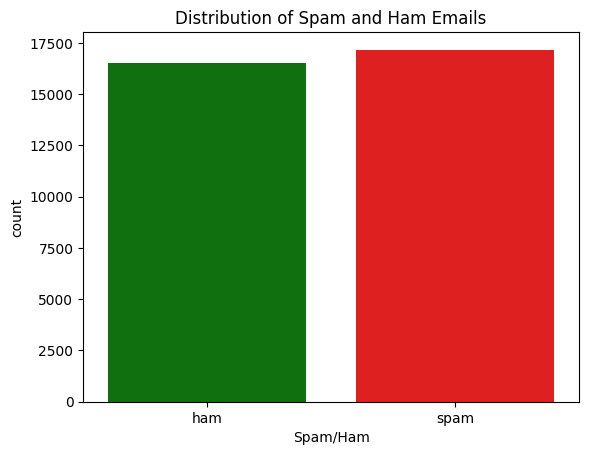

In [5]:
# @title Visualizing the distribution of Spam and Ham emails
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='Spam/Ham', data=df, palette = ["green", "red"])
plt.title('Distribution of Spam and Ham Emails')
plt.show()


In [6]:
# @title Relabeling the data
df['label'] = df['Spam/Ham'].map( {'spam': 1, 'ham': 0} )

In [7]:
# @title Combining the subject and email body
df = df.dropna(subset=['Subject', 'Message']) # Removing empty rows
df['text'] = df['Subject'] + " " + df['Message'] # Merging the Subject and the email body into a single column
df = df.drop(columns=['Spam/Ham','Subject', 'Message','Message ID', 'Date'])
df.isnull().sum()

<ipython-input-7-15aab904ac23>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['Subject'] + " " + df['Message'] # Merging the Subject and the email body into a single column


label    0
text     0
dtype: int64

dobmeos with hgh my energy lev
vastar resources , inc . gary 


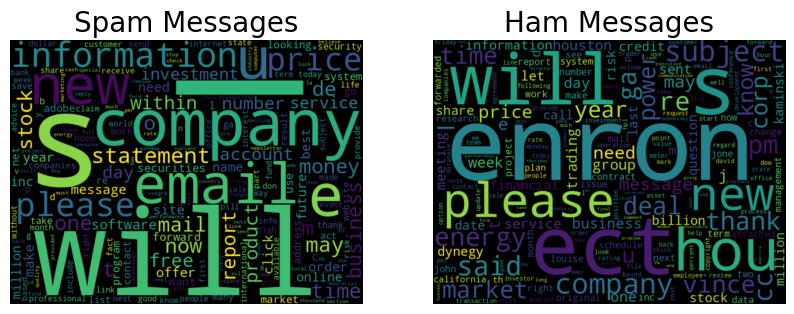

In [8]:
# @title Wordcloud visualization without stop words
data_ham = df[df['label'] == 0].copy()
data_spam = df[df['label'] == 1].copy()

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import wordcloud

def show_wordcloud(data, title, subplot_number):
    text = ' '.join(data['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    print(text[:30])
    fig_wordcloud = WordCloud(stopwords=stopwords, width=800, height=600,
                              collocations=False).generate(text)

    plt.subplot(subplot_number)
    plt.imshow(fig_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)

plt.figure(figsize=(10, 12))
show_wordcloud(data_spam, "Spam Messages", 121)
show_wordcloud(data_ham, "Ham Messages", 122)
plt.show()


## Task 3 - Text Preprocessing

Based on analysis of the given dataset, we can see that there are many misspelled words and chat words, most commonly 'FYI' which needs to be addressed during the preprocessing. This will help in dimensionality reduction and removal extracting the true meaning of chat abbreviation.

The main goal here is to remove any unnecessary words or characters and retaining words that have meaning and that is by ensuring we filter out as many things that are unnecessary and ensuring that we merge words that are the same but written differently.

The text data is then preprocessed by implementing the below techniques to improve the accuracy of our spam email classifier later in this project.

1. removing punctuation - this is done mainly for dimensionality reduction as it does not give us any information on whether the email is spam or ham
2. removing numbers - this is also done for dimentionality reduction as numbers can take on many forms and give no information on whether it is spam or ham
3. special characters - special characters are also unnecessary to have
4. expanding chat words - our dataset consists of chat words such as fyi
5. spelling correction - spell correction for dimentionality reduction
6. converting to lower case - for dimensionality reduction
7. removing stop words - for dimensionality reduction
8. lemmatization for dimensionality reduction and retaining the meaning

In [9]:
!pip install pyspellchecker

In [10]:
# @title Importing necessary libraries
import re
import nltk
import string
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# @title Chat words conversion

chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

chat_words_conversion("fyi minute BRB")

'For Your Information minute Be Right Back'

In [12]:
# @title Lemmatizer
# Creating the lemmatizer function
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
  return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

In [13]:
# @title Check Spelling
from spellchecker import SpellChecker

spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    for word in text.split():
        if word in spell:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)


In [14]:
# @title Clean text

def clean_text(text):
    # Remove punctuation, numbers, special characters, and keep only English alphabets
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Expand chat words
    text = chat_words_conversion(text)
    # Spell correction
    text = correct_spellings(text)
    # Lowercase
    text = text.lower()
    # Lemmatization
    text = lemmatize_words(text)
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)

    # Correct spellings and remove stopwords
    filtered_text = [token for token in word_tokens if token not in stop_words]

    # Join the words back into a sentence
    return ' '.join(filtered_text)

# Apply clean_text to each email
df['cleaned_text'] = df['text'].apply(clean_text)




In [15]:
df.head()

,label,text,cleaned_text
1,0,"vastar resources , inc . gary , production fro...",vastar resource inc gary production high islan...
2,0,calpine daily gas nomination - calpine daily g...,calpine daily gas nomination calpine daily gas...
3,0,re : issue fyi - see note below - already done...,issue information see note already done stella...
4,0,meter 7268 nov allocation fyi .\n- - - - - - -...,meter nov allocation information forwarded lau...
5,0,"mcmullen gas for 11 / 99 jackie ,\nsince the i...",mcmullen gas jackie since inlet river plant sh...


## Task 4 - Text Representation

In this section, the cleaned text is converted into different Text Representation forms.

POS tagging allows us to retain the context of the words which will provide greater insight on the way the word was used in the sentence.

TF-IDF allows us to understand the value of each word based on its occurrence throughout the different email messages.

Bag of Words is another way of representing words in a Document Term matrix. This allows us to vectorize the words making it easier for the machine to infer the prominence of each word.

Word Embeddings is another way of representing the words meaning. This is by creating a vector for each word representing its meaning based on a multiplie factors such as its position in a sentence as well as the words are adjacent to it.

In [16]:
# @title POS Tagging
nltk.download('averaged_perceptron_tagger')

# Function to tag parts of speech in a sentence
def pos_tag_text(text):
    word_tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(word_tokens)
    return pos_tags

# Apply POS tagging to the cleaned text
df['pos_tags'] = df['cleaned_text'].apply(pos_tag_text)
df['pos_tags'].head()


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


1    [(vastar, NN), (resource, NN), (inc, NN), (gar...
2    [(calpine, JJ), (daily, JJ), (gas, NN), (nomin...
3    [(issue, NN), (information, NN), (see, VBP), (...
4    [(meter, NN), (nov, DT), (allocation, NN), (in...
5    [(mcmullen, NN), (gas, NN), (jackie, NN), (sin...
Name: pos_tags, dtype: object

In [17]:
# @title TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])


In [18]:
# Display TF-IDF shape
X_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
# @title Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer with ngram_range and stop_words parameters
CountVec = CountVectorizer(ngram_range=(1, 1), stop_words='english')
# Transform the sentences
X_bow = CountVec.fit_transform(df['cleaned_text'])
# Create a DataFrame to display the word counts
cv_dataframe = pd.DataFrame(X_bow.toarray(), columns=CountVec.get_feature_names_out())
# Print the DataFrame
print(cv_dataframe)

       aa  aaa  aaaa  aaaacy  aaaahhhhhh  ...  zzyudgpd  zzzglvaa  zzzxlqbha  \
0       0    0     0       0           0  ...         0         0          0   
1       0    0     0       0           0  ...         0         0          0   
2       0    0     0       0           0  ...         0         0          0   
3       0    0     0       0           0  ...         0         0          0   
4       0    0     0       0           0  ...         0         0          0   
...    ..  ...   ...     ...         ...  ...       ...       ...        ...   
33102   0    0     0       0           0  ...         0         0          0   
33103   0    0     0       0           0  ...         0         0          0   
33104   0    0     0       0           0  ...         0         0          0   
33105   0    0     0       0           0  ...         0         0          0   
33106   0    0     0       0           0  ...         0         0          0   

       zzzz  zzzzcards  
0         0   

In [20]:
# @title Word Embeddings
from gensim.models import Word2Vec

# Tokenize the cleaned text
sentences = df['cleaned_text'].apply(word_tokenize)

# Create Word2Vec model
model = Word2Vec(sentences=sentences, min_count=1)

In [21]:
# Use the model to get the vector for a word
vector = model.wv['money']
vector

array([-2.4467866 , -1.2765266 ,  2.071488  ,  0.40331793,  0.8655659 ,
       -4.051381  ,  1.5244392 , -0.7635292 , -0.4691282 , -1.8985937 ,
       -1.4641804 , -5.453334  ,  3.356222  ,  1.0688788 ,  5.364109  ,
        0.22136065, -2.7383912 , -0.26038343,  1.3536704 , -0.21434313,
       -1.3213553 , -2.520154  , -0.41757363,  3.4141786 ,  1.1035278 ,
        0.93098867,  0.2720421 ,  0.1709328 , -1.2750338 ,  2.1077218 ,
        2.039386  , -1.0160373 , -0.96405846, -1.5867707 , -2.183188  ,
        1.3580672 , -4.7429156 , -0.7326683 ,  2.5570016 , -2.7231956 ,
        2.0179343 , -2.6856642 ,  0.51671815, -0.9510658 , -0.38884488,
       -3.8494036 ,  1.867524  , -0.37570888,  1.6083459 , -0.90899765,
        3.180945  ,  1.1686629 ,  0.75067157,  0.9066858 , -3.8787572 ,
        2.0214446 ,  1.6061287 , -0.844545  ,  0.6884188 , -0.6974976 ,
        2.6206565 ,  1.1721363 ,  2.4577396 , -2.6241171 , -2.642647  ,
        1.5641084 , -3.8559732 ,  0.86088026,  2.0743382 ,  1.05

In [22]:
# Finding words that are similar
similar = model.wv.most_similar('money')
similar

[('fund', 0.6395794153213501),
 ('monies', 0.6190886497497559),
 ('deposit', 0.614574134349823),
 ('kept', 0.5968888401985168),
 ('willing', 0.5824550986289978),
 ('charity', 0.5724709630012512),
 ('guarantee', 0.5718528032302856),
 ('beneficiary', 0.5653043985366821),
 ('least', 0.5619584321975708),
 ('consignment', 0.560955822467804)]

## Task 5 –Text Classification / Prediction

The two Text Classification algorithms that will be used in this section are Multinomial Naive Bayes and Logistic Regression.

From what was learned through the NLP course is that these two classifiers are well suited for predicting discrete features such as our case where we have either spam labeled as 1 or ham labeled as 0.

Additionally, we will be utilizing two different feature extraction methods, the Bag of Words and TF-IDF with both the algorithms to see if there are any difference in each.

In [57]:
# @title Importing Libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

from time import time

import warnings
warnings.filterwarnings("ignore")

In [58]:
# @title Preparing test set for both BOW and TF IDF
#Train-Test Split
SEED=123

y = df['label']

X_train_bow,X_test_bow,y_train_bow,y_test_bow = train_test_split(X_bow, y, test_size=0.3, random_state=SEED, stratify=y)
X_train_tfidf,X_test_tfidf,y_train_tfidf,y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.3, random_state=SEED, stratify=y)

print("Bag of Words training set: \t", X_train_bow.shape, y_train_bow.shape)
print("Bag of Words test set: \t\t", X_test_bow.shape, y_test_bow.shape)

print("TF-IDF training set: \t\t", X_train_tfidf.shape, y_train_tfidf.shape)
print("TF-IDF test set: \t\t", X_test_tfidf.shape, y_test_tfidf.shape)


Bag of Words training set: 	 (23174, 134284) (23174,)
Bag of Words test set: 		 (9933, 134284) (9933,)
TF-IDF training set: 		 (23174, 5000) (23174,)
TF-IDF test set: 		 (9933, 5000) (9933,)


### Multinomial Naive Bayes

In [59]:
# @title Using Bag of Words
bow_mnb = MultinomialNB()
%time bow_mnb.fit(X_train_bow, y_train_bow)

y_pred_train_bow_mnb = bow_mnb.predict(X_train_bow)
y_pred_test_bow_mnb = bow_mnb.predict(X_test_bow)
print("\nTraining Accuracy score:",accuracy_score(y_train_bow, y_pred_train_bow_mnb))
print("Testing Accuracy score:",accuracy_score(y_test_bow, y_pred_test_bow_mnb))

CPU times: user 19.9 ms, sys: 2.94 ms, total: 22.8 ms
Wall time: 25.4 ms

Training Accuracy score: 0.9911970311556054
Testing Accuracy score: 0.9877177086479412


In [60]:
# @title Using TF-IDF
tfidf_mnb = MultinomialNB()
%time tfidf_mnb.fit(X_train_tfidf, y_train_tfidf)

y_pred_train_tfidf_mnb = tfidf_mnb.predict(X_train_tfidf)
y_pred_test_tfidf_mnb = tfidf_mnb.predict(X_test_tfidf)
print("\nTraining Accuracy score:",accuracy_score(y_train_tfidf, y_pred_train_tfidf_mnb))
print("Testing Accuracy score:",accuracy_score(y_test_tfidf, y_pred_test_tfidf_mnb))

CPU times: user 13.3 ms, sys: 0 ns, total: 13.3 ms
Wall time: 18.2 ms

Training Accuracy score: 0.9828687321998791
Testing Accuracy score: 0.9817779120104702


### Logistic Regression Classifier

In [61]:
# @title Using Bag of Words
bow_lr = LogisticRegression(random_state=SEED)
%time bow_lr.fit(X_train_bow, y_train_bow)

y_pred_train_bow_lr = bow_lr.predict(X_train_bow)
y_pred_test_bow_lr = bow_lr.predict(X_test_bow)
print("\nTraining Accuracy score:",accuracy_score(y_train_bow, y_pred_train_bow_lr))
print("Testing Accuracy score:",accuracy_score(y_test_bow, y_pred_test_bow_lr))

CPU times: user 4.55 s, sys: 4.05 s, total: 8.59 s
Wall time: 7.25 s

Training Accuracy score: 0.9994821783032709
Testing Accuracy score: 0.9889258028792912


In [62]:
# @title Using TF-IDF

tfidf_lr = LogisticRegression(random_state=SEED)
%time tfidf_lr.fit(X_train_tfidf, y_train_tfidf)

y_pred_train_tfidf_lr = tfidf_lr.predict(X_train_tfidf)
y_pred_test_tfidf_lr = tfidf_lr.predict(X_test_tfidf)
print("\nTraining Accuracy score:",accuracy_score(y_train_tfidf, y_pred_train_tfidf_lr))
print("Testing Accuracy score:",accuracy_score(y_test_tfidf, y_pred_test_tfidf_lr))

CPU times: user 282 ms, sys: 1.99 ms, total: 284 ms
Wall time: 285 ms

Training Accuracy score: 0.9908518166911193
Testing Accuracy score: 0.9869123124937078


## Task 6 – Evaluation , Inferences, Recommendation and Reflection

To evaluate the models peformance, we will be looking at comparing both the algorithms as well as their performance with the use of the two feature extraction methods used.

We will be reviwing the ROC-AUC curve to evaluate the accuracy, the precision as we are mostly concerned about false positives (incorrectly labelling an email as spam)

### Multinomial Naive Bayes

#### Evaluation of With Bag of Words

In [63]:
print(classification_report(y_test_bow, y_pred_test_bow_mnb, target_names=['Ham', 'Spam']))

              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99      4948
        Spam       0.99      0.99      0.99      4985

    accuracy                           0.99      9933
   macro avg       0.99      0.99      0.99      9933
weighted avg       0.99      0.99      0.99      9933



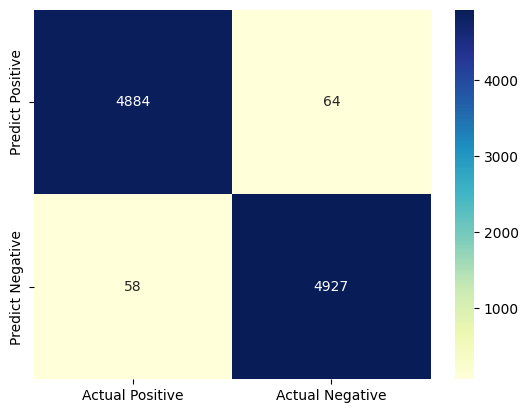

In [64]:
cm = confusion_matrix(y_test_bow, y_pred_test_bow_mnb)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

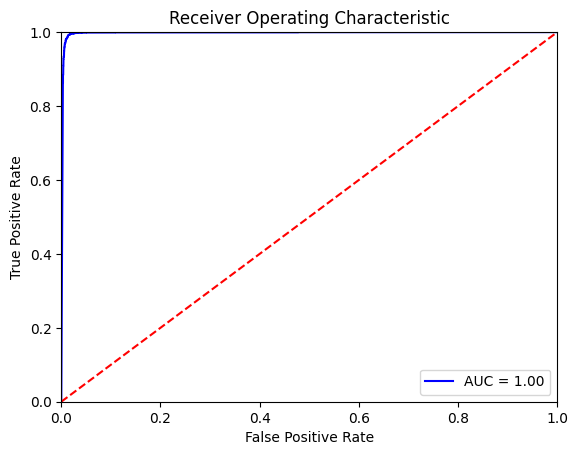

In [65]:
probs = bow_mnb.predict_proba(X_test_bow)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_bow, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### With TF-IDF

In [66]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf_mnb, target_names=['Ham', 'Spam']))

              precision    recall  f1-score   support

         Ham       0.99      0.98      0.98      4948
        Spam       0.98      0.99      0.98      4985

    accuracy                           0.98      9933
   macro avg       0.98      0.98      0.98      9933
weighted avg       0.98      0.98      0.98      9933



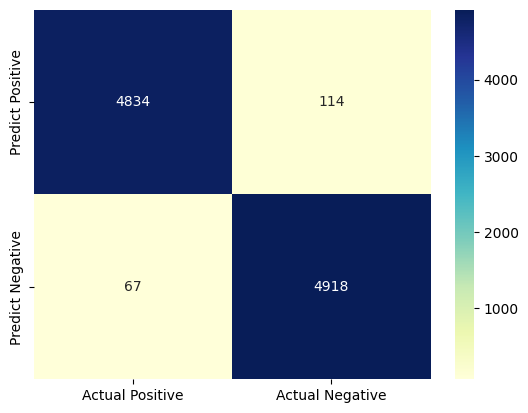

In [67]:
cm = confusion_matrix(y_test_tfidf, y_pred_test_tfidf_mnb)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

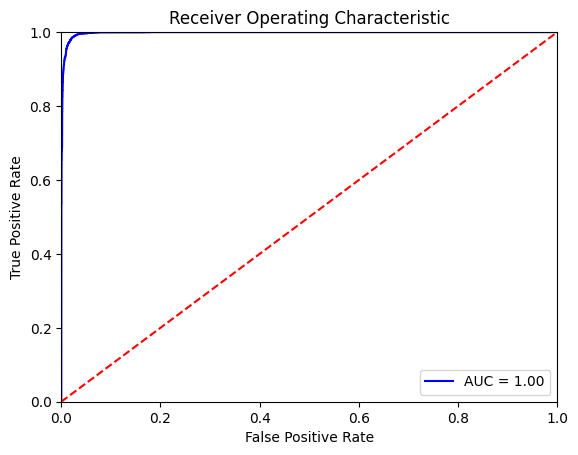

In [68]:
probs = tfidf_mnb.predict_proba(X_test_tfidf)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_tfidf, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Evaluation of Logistic Regression Classifier



#### With Bag of Words

In [69]:
print(classification_report(y_test_bow, y_pred_test_bow_lr, target_names=['Ham', 'Spam']))

              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99      4948
        Spam       0.99      0.99      0.99      4985

    accuracy                           0.99      9933
   macro avg       0.99      0.99      0.99      9933
weighted avg       0.99      0.99      0.99      9933



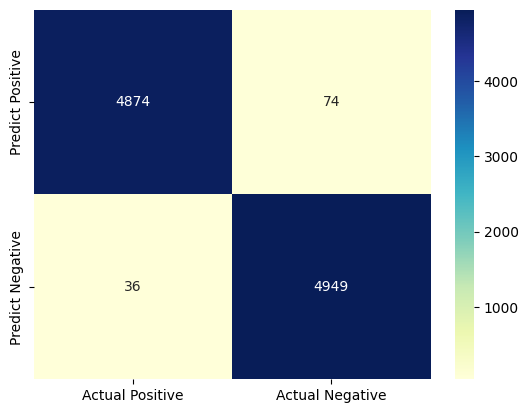

In [70]:
cm = confusion_matrix(y_test_bow, y_pred_test_bow_lr)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

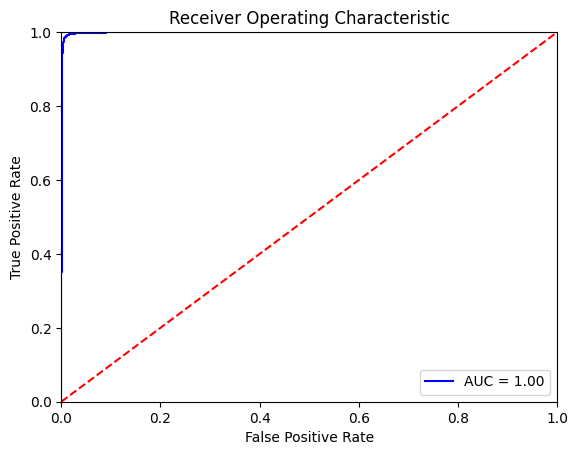

In [71]:
probs = bow_lr.predict_proba(X_test_bow)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_bow, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### With TF-IDF

In [72]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf_lr, target_names=['Ham', 'Spam']))

              precision    recall  f1-score   support

         Ham       0.99      0.98      0.99      4948
        Spam       0.98      0.99      0.99      4985

    accuracy                           0.99      9933
   macro avg       0.99      0.99      0.99      9933
weighted avg       0.99      0.99      0.99      9933



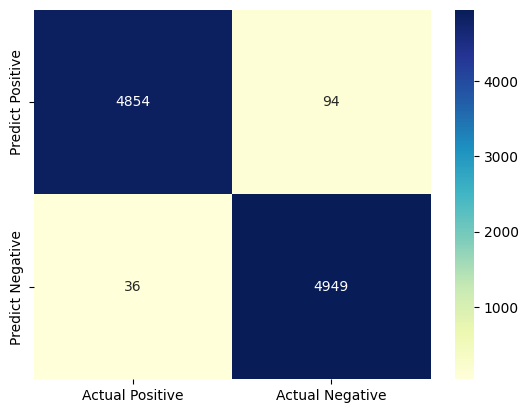

In [73]:
cm = confusion_matrix(y_test_tfidf, y_pred_test_tfidf_lr)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

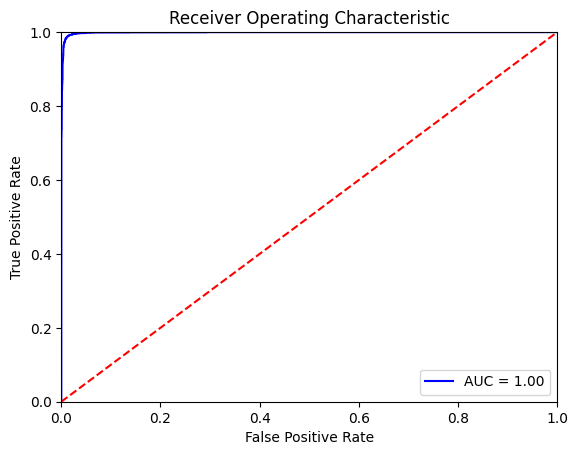

In [74]:
probs = tfidf_lr.predict_proba(X_test_tfidf)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test_tfidf, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Inference, Recommendation and Reflection

In both our evaluations, the BoW set was the more accurate of the two feature extraction methods possibly due to the number of features available: *134284* feature for Bag of Words and *5000* for TF-IDF.

The two classifiers performed great overall, with the Logistic Regression Classifier performing slightly better than the Multinomial Naive Bayes in terms of accuracy.

In our case, we are more concerned with the precision of the model as we cannot accept normal emails (Negative) to be filtered out as the can affect the work, especially if the email was critical in nature. Based on the results, we can measure that Logistic Regression with Bag Of Words performed the best to avoid False Positives.

### Recommendation

Based on the outcome of this project, Logistic Regression with Bag of Words seem to be well-suited for projects related to Spam filtering, despite the slight slowness that it showed during the training.

### Reflection

For future work, it would be great to diversify the dataset by including emails from different organizations besides the Enron Email Corpus. This can possible improve the model by being more generic in nature, allowing us to apply it within any organization.

## References



*   [Github Page](https://github.com/MWiechmann/enron_spam_data) containing the Dataset
*   [Kaggle](https://www.kaggle.com/code/mohitr/simple-spam-filter) implementation of a simple spam filter using Multinomial Naive Bayes
*   [Kaggle](https://www.kaggle.com/code/mfaisalqureshi/email-spam-detection-98-accuracy) implementation of spam filter with 98% accuracy using Mutlinomial Naive Bayes and Bag of words
*   [Kaggle](https://www.kaggle.com/code/adi0509/spam-detection-logistic-regression) implementation of spam filter with 99% accuracy using Logistic Regression and Bag of words




